# Financial Big Data Project
# Caterina La Cava (358741), Léo Lagast (290246)

# Useful libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import gzip
import tarfile
import xlrd
import datetime
import re
import dask
import vaex
import glob
import bahc 
import community
import networkx as nx
from scipy.optimize import minimize
from numpy import linalg as LA
import matplotlib.pyplot as plt
import datetime as datetime

# Functions

In [ ]:
# Load and store data

def get_file_names(folder):
    """
    Function that returns an array of strings, where each string is the name of a file in the folder passed as argument
    Args:
    - folder: path 
    Returns:
    - file_names: array of strings
    """
    file_names = []
    for file in os.listdir(folder):
        file_names.append(file)
        
    return file_names

 
def create_file(file_name, content):
    """
    Creates a file in the data folder, it takes as argument the name of the file and the content of the file
    Args:
    - file_name: name of a file 
    - content: content of the file
    """
    with open(file_name, 'w') as file:
        file.write(content)


def extract_tar(file_path, output_path):
    """
    Extracts the contents of a .tar file to the specified output path.
    Args:
    - file_path: name of a file 
    - output_path: path where the content of the file will be stored
    """
    try:
        with tarfile.open(file_path, 'r') as tar:
            tar.extractall(output_path)
        print(f"Extraction of {file_path} successful.")
    except tarfile.TarError as e:
        print(f"Error extracting {file_path}: {e}")


def extract_csv_gz_file(source_file, destination_directory):
    """
    Extracts a .csv.gz file to a specified directory.
    Args:
    - source_file: The path to the .csv.gz file to be extracted.
    - destination_directory: The directory where the extracted file will be saved.
    """
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)
    try:
        file_name = os.path.basename(source_file)
        output_file = os.path.join(destination_directory, os.path.splitext(file_name)[0])
        with gzip.open(source_file, 'rb') as f_in, open(output_file, 'wb') as f_out:
            f_out.write(f_in.read())
        print(f"File extracted to: {output_file}")
    except Exception as e:
        print(f"Error extracting file: {e}")


def xl_to_datetime(xltime):
    """
    Transforms xltime into an object datetime
    Args:
    - xltime: float
    Returns:
    - date_time_obj: datetime object
    """
    date_value = int(xltime)
    time_value = (xltime - date_value) * 24 * 60 * 60  # Convert fraction of a day to seconds
    date_tuple = xlrd.xldate_as_tuple(date_value, 0)  # 0 for 1900-based date system
    year, month, day, hour, minute, second = date_tuple
    date_time_obj = datetime.datetime(year, month, day, hour, minute, second) + datetime.timedelta(seconds=time_value)

    return date_time_obj


def convert_to_float(value):
    """
    Converts the value to float if it is possible, otherwise it returns nan
    Args:
    - value: float
    Returns:
    - float_value: or a float or nan
    """
    try:
        float_value = float(value)
        return float_value if np.isfinite(float_value) else np.nan
    except (ValueError, TypeError):
        return np.nan
    

def resample_df(df):
    """
    Resamples the dataframe df to 1 minute frequency; one apply the function xl_to_datetime to the column xltime of merged_df
    Args:
    - df: dataframe
    Returns:
    -  df: resampled dataframe
    """
    df['datetime'] = df['xltime'].apply(xl_to_datetime)
    df['bid-price'] = df['bid-price'].astype(float)
    df['ask-price'] = df['ask-price'].astype(float)
    df['bid-volume'] = df['bid-volume'].astype(float)
    df['ask-volume'] = df['ask-volume'].astype(float)

    #drop the column xltime
    df = df.drop(columns=['xltime'])

    #set the column datetime as index
    df = df.set_index('datetime')
    df = df.resample('1T').agg({
        'bid-price': 'mean',
        'ask-price': 'mean',
        'bid-volume': 'sum',
        'ask-volume': 'sum'
    })

    return df


def create_folder(directory_path, folder_name):
    """
    Combines directory path and folder name to create the full path for the new folder
    Args:
    - directory_path: path
    - folder_name: name of the folder
    """
    new_folder_path = os.path.join(directory_path, folder_name)

    # Create the new folder if it doesn't already exist
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)


def clean_dataframe(df):
    """
    Cleans the dataframe in input by replacing the non-float values with the previous value
    Args:
    - df: dataframe
    Returns:
    - df: cleaned dataframe
    """
    for column_name in df.columns[1:]:
        # Convert the column to numeric, coercing non-numeric values to NaN
        numeric_column = pd.to_numeric(df[column_name], errors='coerce')
        mean_value = numeric_column.mean()
        if isinstance(df[column_name][0], float)==False:
            df[column_name][0] = mean_value
        for row in range(1, len(df[column_name])):
            if isinstance(df[column_name][row], float)==False:
                df[column_name][row] = df[column_name][row-1]

    return df
        

def clean_dataframe_faster(df):
    """
    Cleans the dataframe in input by replacing the non-float values with the previous value
    Args:
    - df: dataframe
    Returns:
    - df: cleaned dataframe
    """
    for column_name in df.columns[1:]:
        # Convert the column to numeric, coercing non-numeric values to NaN
        numeric_column = pd.to_numeric(df[column_name], errors='coerce')
        mean_value = numeric_column.mean()
        
        # Use vectorized operations to replace non-float values
        non_float_mask = ~pd.api.types.is_float_dtype(df[column_name])
        
        df.loc[non_float_mask, column_name] = df[column_name].shift(1)
        df.loc[0, column_name] = mean_value

    return df


dask.config.set(scheduler="processes")
@dask.delayed
def load_trade(filename,
             tz_exchange="America/New_York",
             only_non_special_trades=True,
             only_regular_trading_hours=True,
             open_time="09:30:00",
             close_time="16:00:00",
             merge_sub_trades=True):
    """
    Loads a trade files 
    Args:
    - filename: name of the file
    - tz_exchange: timezone
    - only_non_special_trades: boolean
    - only_regular_trading_hours: boolean
    - open_time: string
    - close_time: string
    - merge_sub_trades: boolean
    Returns:
    - DF: dataframe
    """
    try:
        if re.search('(csv|csv\\.gz)$',filename):
            DF = pd.read_csv(filename, engine = "pyarrow")
        if re.search(r'arrow$',filename):
            DF = pd.read_arrow(filename)
        if re.search('parquet$',filename):
            DF = pd.read_parquet(filename)
    except Exception as e:
        return None
    try:
        DF.shape
    except Exception as e: 
        print("DF does not exist")
        print(e)
        return None
    if DF.shape[0]==0:
        return None
    if only_non_special_trades:
        DF = DF[DF["trade-stringflag"]=="uncategorized"]
    DF.drop(columns=["trade-rawflag","trade-stringflag"],axis=1,inplace=True)
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
    if merge_sub_trades:
           DF=DF.groupby(DF.index).agg(trade_price=pd.NamedAgg(column='trade-price', aggfunc='mean'),
                                       trade_volume=pd.NamedAgg(column='trade-volume', aggfunc='sum'))
           
    return DF


@dask.delayed
def load_bbo(filename,
             only_regular_trading_hours=True,
             merge_sub_trades=True):
    """
    Loads a bbo files
    Args:
    - filename: name of the file
    - only_regular_trading_hours: boolean
    - merge_sub_trades: boolean
    Returns:
    - DF: dataframe
    """

    try:
        if re.search(r'(csv|csv\.gz)$',filename):
            DF = pd.read_csv(filename)
        if re.search(r'arrow$',filename):
            DF = pd.read_arrow(filename)
        if re.search(r'parquet$',filename):
            DF = pd.read_parquet(filename) 
    except Exception as e:
        return None
    try:
        DF.shape
    except Exception as e: # DF does not exist
        print("DF does not exist")
        print(e)
        return None
    if DF.shape[0]==0:
        return None
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    if only_regular_trading_hours:
        DF=DF.between_time("09:30:00","16:00:00")    # ever heard about Thanksgivings?
    if merge_sub_trades:
        DF=DF.groupby(DF.index).last()

    return DF


@dask.delayed
def load_merge_trade_bbo(ticker,date,
                         dirBase="data/raw/sp100_2004-8/",
                         suffix="csv.gz",
                         suffix_save=None,
                         dirSaveBase="data/clean/sp100_2004-8/events",
                         saveOnly=False,
                         doSave=False
                        ):
    """
    Loads and merges the trade and bbo files
    Args:
    - ticker: name of the ticker
    - date: date
    - dirBase: directory
    - suffix: suffix
    - suffix_save: suffix
    - dirSaveBase: directory
    - saveOnly: boolean
    - doSave: boolean
    Returns:
    - events: dataframe
    """
    file_trade=dirBase+"/"+"/trade/"+ticker+"/"+str(date.date())+"-"+ticker+"-trade."+suffix
    file_bbo=file_trade.replace("trade","bbo")
    trades=load_trade(file_trade)
    bbos  =load_bbo(file_bbo)
    try:
        trades.shape + bbos.shape
    except:
        return None
    
    events=trades.join(bbos,how="outer")
    
    if doSave:
        dirSave=dirSaveBase+"/"+"/events/"+ticker
        if not os.path.isdir(dirSave):
            os.makedirs(dirSave)

        if suffix_save:
            suffix=suffix_save
        
        file_events=dirSave+"/"+str(date.date())+"-"+ticker+"-events"+"."+suffix

        saved=False
        if suffix=="arrow":
            events=vaex.from_pandas(events,copy_index=True)
            events.export_arrow(file_events)
            saved=True
        if suffix=="parquet":
         #   pdb.set_trace()
            events.to_parquet(file_events,use_deprecated_int96_timestamps=True)
            saved=True
            
        if not saved:
            print("suffix "+suffix+" : format not recognized")
            
        if saveOnly:
            return saved
        
    return events


def data_to_parquet(ticker):
    """
    Loads the data of the ticker in input from the raw folder, cleans it and stores it in the clean folder
    Args:
    - ticker: name of the ticker
    """
    if ~os.path.exists(f"data/clean/sp100_2004-8/{ticker}.parquet"):
        trade_files=glob.glob(f"data/raw/sp100_2004-8/trade/{ticker}/*.csv.gz")
        # we have a name for each trading file that we find in the directory; each trading file correspond to one 
        # trading day 
        trade_files.sort()
        allpromises=[load_trade(fn) for fn in trade_files]
        trades=dask.compute(allpromises)[0]
        trades=pd.concat(trades)

        bbo_files=glob.glob(f"data/raw/sp100_2004-8/bbo/{ticker}/*.csv.gz")
        bbo_files.sort()
        allpromises=[load_bbo(fn) for fn in bbo_files]
        bbos=dask.compute(allpromises)[0]
        bbos=pd.concat(bbos)

        events=trades.join(bbos,how="outer")

        # Filling NaNs in 'ask_price' column with the last known value from 'ask_price' column
        events = events.replace('()', np.nan)
        events['ask-price'] = events['ask-price'].bfill()
        events['bid-price'] = events['bid-price'].bfill()
        events['ask-volume'] = events['ask-volume'].bfill()
        events['bid-volume'] = events['bid-volume'].bfill()
        events['ask-price'] = events['ask-price'].ffill()
        events['bid-price'] = events['bid-price'].ffill()
        events['ask-volume'] = events['ask-volume'].ffill()
        events['bid-volume'] = events['bid-volume'].ffill()

        events = events.dropna(subset=['trade_price'])
        events["bid-price"] = events["bid-price"].values.astype("float")
        events["bid-volume"]=events["bid-volume"].values.astype("float")
        events["ask-price"]=events["ask-price"].values.astype("float")
        events["ask-volume"]=events["ask-volume"].values.astype("float")

        events.to_parquet(f"data/clean/sp100_2004-8/{ticker}.parquet")
    

def process_parquet_files(tickers, trading_returns):
    """
    Loads the data of the tickers in input from the clean folder, resamples it and stores it in the resampled folder
    Args:
    - tickers: array of tickers
    - trading_returns: dataframe
    Returns:
    - trading_returns: resampled, cleaned dataframe of trading returns
    """
    for ticker in tickers: 
        df = pd.read_parquet(f"data/clean/sp100_2004-8/{ticker}")
        df = df.resample('1T').mean().dropna()
        df_prices = df.drop(columns=['trade_volume', 'bid-volume', 'ask-volume'])
        df_returns = (df_prices / df_prices.shift(1) - 1).dropna() 
        trading_returns = pd.concat([trading_returns, df_returns['trade_price'].to_frame(name= ticker[:-8])], axis=1, join='outer')
        trading_returns.ffill(inplace=True)
        trading_returns.bfill(inplace=True)

    for column in trading_returns.columns:
        trading_returns[column] = np.where(np.abs(trading_returns[column]) > 0.1, 0.1 * np.sign(trading_returns[column]), trading_returns[column])

    return trading_returns


# Covariance matrix 

def covariance_matrix(trading_returns_df, if_bahc = False, corr_with_bahc = False): 
    """
    Computes the covariance matrix of the trading returns dataframe
    Args:
    - trading_returns_df: dataframe
    - bahc: boolean
    Returns:
    - cov_matrix: covariance matrix
    """
    if if_bahc: 
        if corr_with_bahc: 
            corr = bahc.filterCovariance(trading_returns_df.T.to_numpy(), K = 1, Nboot=50, is_correlation=True)
        else: 
            corr = trading_returns_df.corr()
        cov_matrix = bahc.filterCovariance(trading_returns_df.T.to_numpy(), K = 1, Nboot=50)

        return corr, cov_matrix, 0
    else: 
        # number of timesteps
        T = trading_returns_df.shape[0] 
        initial_corr = trading_returns_df.corr()
        # number of assets
        N = initial_corr.shape[0] 
        if N>T: 
            print("N is bigger than T and risk estimation error may diverge")
        q = N/T
        eigenvalues_e, eigenvectors_e = LA.eig(initial_corr)
        lambda_plus = (1+np.sqrt(q))**2
        # number of eigenvalues outside of the random bulk
        outside_bulk_eigenvalues = np.sum(eigenvalues_e>lambda_plus)
        corr_clipped = eigenvalue_clipping(eigenvalues_e,eigenvectors_e,lambda_plus)
        # from correlation matrix to covariance matrix
        trading_std = np.array(trading_returns_df.std())
        cov_matrix = np.outer(trading_std, trading_std) * np.array(corr_clipped)

        return corr_clipped, cov_matrix, outside_bulk_eigenvalues


def eigenvalue_clipping(lambdas,v,lambda_plus):
    """ 
    Clips the eigenvalues of the correlation matrix to lambda_plus
    Args:
    - lambdas: eigenvalues
    - v: eigenvectors
    - lambda_plus: threshold
    Returns:
    - C_clean: clipped correlation matrix
    """
    N=len(lambdas)
    sel_bulk=lambdas<=lambda_plus            
    N_bulk=np.sum(sel_bulk)
    sum_lambda_bulk=np.sum(lambdas[sel_bulk])        
    delta=sum_lambda_bulk/N_bulk           
    lambdas_clean=lambdas
    lambdas_clean[lambdas_clean<=lambda_plus]=delta
    C_clean=np.zeros((N, N))
    v_m=np.matrix(v)
    for i in range(N-1):
        C_clean=C_clean+lambdas_clean[i] * np.dot(v_m[i,].T,v_m[i,]) 
        
    np.fill_diagonal(C_clean,1)
            
    return C_clean    


# Clustering function to decide which clustering algorithm to use

def clustering(returns_df, if_marsili_giada = False, if_bahc = False):
    """
    Computes the clusters of the returns dataframe
    Args:
    - returns_df: dataframe
    - if_marsili_giada: boolean
    - if_bahc: boolean
    Returns:
    - clusters_constituents: dictionary
    - sub_portfolios: array of strings
    - sub_portfolios_returns: dataframe
    """
    if if_marsili_giada: 
        corr_matrix, cov_matrix, eigenvalue_clipping = covariance_matrix(returns_df, if_bahc, True )
        last_cluster = aggregate_clusters(corr_matrix)
        s_i = last_cluster['s_i']
        marsili_clusters = pd.DataFrame()
        marsili_clusters.index = returns_df.columns
        marsili_clusters[0] = s_i 
        array_of_numbers = marsili_clusters[0].unique()
        for i in range(0, len(marsili_clusters[0].unique())): 
            marsili_clusters[0] = np.where(marsili_clusters[0] == array_of_numbers[i], i, marsili_clusters[0])
        clusters = marsili_clusters
        clusters_dict =  marsili_clusters[0].to_dict()

    else: 
        louvain_clusters = LouvainCorrelationClustering(returns_df)
        louvain_clusters.index = returns_df.columns
        clusters = louvain_clusters
        clusters_dict = louvain_clusters[0].to_dict()
        
    sub_portfolios_returns = pd.DataFrame(0.0, index = returns_df.index, columns = ['sub_pf_{}'.format(i) for i in range(clusters.max().max() + 1)])
    sub_portfolios = ["sub_pf_{}".format(i+1) for i in range(clusters.max().max() + 1)]
    clusters_constituents = {}
    for letter, value in clusters_dict.items():
        clusters_constituents.setdefault(value, []).append(letter)

    return clusters_constituents, sub_portfolios, sub_portfolios_returns


# Marsili Giada clustering algorithm 

def expand_grid_unique(x, y, include_equals=False):
    """
    Expands the grid of unique values
    Args:
    - x: array
    - y: array
    - include_equals: boolean
    Returns:
    - combinations: array
    """
    x = list(set(x))
    y = list(set(y))

    def g(i):
        z = [val for val in y if val not in x[:i - include_equals]]
        if z:
            return [x[i - 1]] + z

    combinations = [g(i) for i in range(1, len(x) + 1)]

    return [combo for combo in combinations if combo]


def max_likelihood(c, n):
    """
    Computes the maximum likelihood
    Args:
    - c: float
    - n: float
    Returns:
    - max_likelihood: float
    """
    if n > 1:
        return np.log(n / c) + (n - 1) * np.log((n * n - n) / (n * n - c))
    else:
        return 0

def max_likelihood_list(cs, ns):
    """
    Computes the maximum likelihood of a list
    Args:
    - cs: dictionary
    - ns: dictionary
    Returns:
    - Lc: dictionary
    """
    Lc = {}
    for x in cs.keys():
        if ns[x] > 1:
            Lc[x] = np.log(ns[x] / cs[x]) + (ns[x] - 1) * np.log((ns[x] * ns[x] - ns[x]) / (ns[x] * ns[x] - cs[x]))
        else:
            Lc[x] = 0

    return Lc

def find_max_improving_pair(C, cs, ns, i_s):
    """
    Finds the maximum improving pair
    Args:
    - C: matrix
    - cs: dictionary
    - ns: dictionary
    - i_s: dictionary
    Returns:
    - pair_max_improv: array
    - Lc_max_impr: float
    - Lc_old: array
    """
    Lc_old = max_likelihood_list(cs, ns)
    names_cs = list(cs.keys())
    max_impr = -1e10
    pair_max_improv = []
    
    for i in names_cs[:-1]:
        names_cs_j = names_cs[names_cs.index(i) + 1:]
        for j in names_cs_j:
            ns_new = ns[i] + ns[j]
            i_s_new = i_s[i] + i_s[j]
            cs_new = np.sum(C[np.ix_(i_s_new, i_s_new)])
            max_likelihood_new = max_likelihood(cs_new, ns_new)
            improvement = max_likelihood_new - Lc_old[i] - Lc_old[j]

            if improvement > max_impr:
                max_impr = improvement
                pair_max_improv = [i, j]
                Lc_max_impr = max_likelihood_new

    return {"pair": pair_max_improv, "Lc_new": Lc_max_impr, "Lc_old": [Lc_old[x] for x in pair_max_improv]}

def aggregate_clusters(C):
    """
    Aggregates the clusters
    Args:
    - C: matrix
    Returns:
    - last_clusters: dictionary
    """
    N = C.shape[0]
    cs = {i: 1 for i in range(N)}
    s_i = {i: [i] for i in range(N)}
    ns = {i: 1 for i in range(N)}
    i_s = {i: [i] for i in range(N)}
    clusters = []

    for i in range(1, N):  # hierarchical merging
        improvement = find_max_improving_pair(C, cs, ns, i_s)
        Lc_old = improvement['Lc_old']
        Lc_new = improvement['Lc_new']
        
        if Lc_new < sum(Lc_old):
            print(" HALF CLUSTER  Lc.new > max(Lc.old)")
            
        if Lc_new <= max(Lc_old):
            print("Lc.new <= max(Lc.old), exiting")
            break
            
        pair = improvement['pair']
        s_i = [pair[0] if x == pair[1] else x for x in s_i]
    
        cluster1 = pair[0]
        cluster2 = pair[1]
        i_s[cluster1].extend(i_s[cluster2])  # merge the elements of the two clusters
        del i_s[cluster2]  # removes reference to merged cluster2
    
        ns[cluster1] += ns[cluster2]
        del ns[cluster2]
    
        cs[cluster1] = np.sum(C[i_s[cluster1]][:, i_s[cluster1]])  # sums C over the elements of cluster1
        del cs[cluster2]
    
        clusters.append({
            'Lc': max_likelihood_list(cs, ns),
            'pair_merged': pair,
            's_i': s_i,
            'i_s': i_s,
            'cs': cs,
            'ns': ns
        })
    
    last_clusters = clusters[-1]

    return last_clusters


# Louvain clustering algorithm
    
def LouvainCorrelationClustering(R):  
    """
    Computes the Louvain clustering of the returns matrix R
    Args:
    - R: matrix of returns
    Returns:
    - DF: dataframe
    """
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)     
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    
    mygraph= nx.from_numpy_matrix(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph)

    DF=pd.DataFrame.from_dict(partition,orient="index")

    return(DF)


def compute_C_minus_C0(lambdas,v,lambda_plus,removeMarketMode=True):
    """
    Computes the correlation matrix C minus C0
    Args:
    - lambdas: eigenvalues
    - v: eigenvectors
    - lambda_plus: threshold
    - removeMarketMode: boolean
    Returns:
    - C_clean: correlation matrix
    """
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]
    
    v_m=np.matrix(v)

    for i in range(1*removeMarketMode,N):                            
        if lambdas[i]>lambda_plus: 
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)  

    return C_clean    
    

# Portfolios construction
# Part of the following code comes from https://quantdare.com/risk-parity-in-python/ and has 
# been adapted to our needs.

def portfolios_construction(clusters_constituents, returns, dates, sub_portfolios_returns, if_bahc = False):
    """
    Constructs the portfolios
    Args:
    - clusters_constituents: dictionary
    - returns: dataframe
    - dates: array
    - sub_portfolios_returns: dataframe
    - if_bahc: boolean
    Returns:
    - portfolio_cumprod: cumulative returns dataframe
    - portfolio_return: portfolio returns dataframe
    """
    for cluster in clusters_constituents.keys():
        df_without_0, stocks_to_be_removed = remove_bad_columns(returns[clusters_constituents[cluster]].loc[dates[0]])
        corr_clipped, cov_matrix, outside_bulk_eigenvalues = covariance_matrix(df_without_0, if_bahc)
        w_mv = compute_mv_weights(cov_matrix)

        for date in dates[1:]:
            clusters_constituents_without_stocks_to_be_removed = [name for name in clusters_constituents[cluster] if name not in stocks_to_be_removed]
            df_without_0, stocks_to_be_removed = remove_bad_columns(returns[clusters_constituents[cluster]].loc[date])
            corr_clipped, cov_matrix, outside_bulk_eigenvalues = covariance_matrix(df_without_0, if_bahc)
            
            series = pd.Series(np.dot(w_mv.T, returns[clusters_constituents_without_stocks_to_be_removed].loc[date].T))
            series.index = sub_portfolios_returns.loc[date].index
            sub_portfolios_returns[f'sub_pf_{cluster}'].loc[date] = series
            
            w_mv = compute_mv_weights(cov_matrix)

    # sub_portfolios_returns = pd.DataFrame(np.where(np.abs(sub_portfolios_returns) > 0.5, 0.5 * np.sign(sub_portfolios_returns), sub_portfolios_returns))
    date = dates[1]
    portfolio_return = pd.DataFrame(0.0, index = returns.index, columns = ['rp_pf', 'iv_pf', 'mv_pf'])
    rp_weights = pd.DataFrame(0.0, index = dates, columns = ["sub_pf_{}".format(i) for i in range(max(list(clusters_constituents.keys())) + 1)])

    for date in dates[1:]:
        df_without_0, stocks_to_be_removed = remove_bad_columns(sub_portfolios_returns.loc[date])
        corr_clipped, cov_matrix, outside_bulk_eigenvalues = covariance_matrix(sub_portfolios_returns.loc[date], if_bahc)
        w_rp = compute_rp_weights(cov_matrix)
        w_iv = compute_iv_weights(cov_matrix)
        w_mv = compute_mv_weights(cov_matrix)

        series_rp = pd.Series(np.dot(w_rp.T, sub_portfolios_returns.loc[date].T))
        series_rp.index = portfolio_return.loc[date].index
        portfolio_return['rp_pf'].loc[date] = series_rp

        series_iv = pd.Series(np.dot(w_iv.T, sub_portfolios_returns.loc[date].T))
        series_iv.index = portfolio_return.loc[date].index
        portfolio_return['iv_pf'].loc[date] = series_iv

        series_mv = pd.Series(np.dot(w_mv.T, sub_portfolios_returns.loc[date].T))
        series_mv.index = portfolio_return.loc[date].index
        portfolio_return['mv_pf'].loc[date] = series_mv
        
        series_w_rp = pd.Series(w_rp)
        series_w_rp.index = rp_weights.loc[date].index
        rp_weights.loc[date] = series_w_rp

    for column in portfolio_return.columns:
        portfolio_return[column] = np.where(np.abs(portfolio_return[column]) > 0.3, 0.3 * np.sign(portfolio_return[column]), portfolio_return[column])

    portfolio_cumprod = (portfolio_return + 1).cumprod()

    for column in portfolio_cumprod.columns:
        portfolio_cumprod[column] = np.where(np.abs(portfolio_cumprod[column]) > 1.7, 1.7 * np.sign(portfolio_cumprod[column]), portfolio_cumprod[column])


    return portfolio_cumprod, portfolio_return


def compute_mv_weights(cov):
    """
    Computes the weights of a minimal variance portfolio given the covariance matrix
    Args:
    - cov: covariance matrix
    Returns:
    - w: weights
    """
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    D = np.diag(eigenvalues)
    inv_D = np.linalg.inv(D)
    inv_cov = np.dot(np.dot(eigenvectors,inv_D),eigenvectors.T)
    w = inv_cov.dot(np.ones(len(cov))) / np.ones(len(cov)).T.dot(inv_cov).dot(np.ones(len(cov)))

    return w


def compute_iv_weights(cov):
    """
    Computes the weights of an inverse volatility portfolio given the covariance matrix
    Args:
    - cov: covariance matrix
    Returns:
    - w: weights
    """
    w = 1 / np.diag(cov)
    w = w / w.sum()

    return w


def compute_vol(w, cov):
    """
    Computes  the volatility of a portfolio given the weights and the covariance matrix
    Args:
    - w: weights
    - cov: covariance matrix
    Returns:
    - pf_risk: portfolio risk
    """
    pf_risk = np.dot(w, cov).dot(w.T)

    return pf_risk

def compute_assets_risk_contribution(w, cov):
    """
    Computes the contribution of each asset to the risk of the whole portfolio
    Args:
    - w: weights
    - cov: covariance matrix
    Returns:
    - assets_risk_contribution: array of assets risk contribution
    """
    pf_risk = compute_vol(w, cov)
    assets_risk_contribution = np.multiply(w.T, np.dot(cov,w.T))/pf_risk

    return assets_risk_contribution


def objective_function(w, args):
    """
    Objective function to minimize
    Args:
    - w: weights
    - args: arguments
    Returns:
    - error: error
    """
    cov = args[0]
    assets_risk_budget = args[1]
    w = np.matrix(w)
    pf_risk = compute_vol(w, cov)
    assets_risk_contribution = compute_assets_risk_contribution(w, cov)
    assets_risk_target = np.asmatrix(np.multiply(pf_risk, assets_risk_budget))
    error = sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    return error

def compute_rp_weights(cov, constraint_type = 'long'):
    """
    Computes the weights of a risk parity portfolio given the covariance matrix
    Args:
    - cov: covariance matrix
    - constraint_type: type of constraint
    Returns:
    - w: weights
    """
    initial_weights = np.ones(cov.shape[0]) * (1.0 / cov.shape[0])
    assets_risk_budget = np.ones(cov.shape[0]) * (1.0 / cov.shape[0])
    if constraint_type == 'long':
        #constraints for long-only portfolio. sum of weights = 1
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},{'type': 'ineq', 'fun': lambda x: x})
    elif constraint_type == 'long_short':  
        #constraints for long-short portfolio. sum of weights = 0  
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)})
    else:
        raise ValueError('Unknown constraint_type. Only possible values for the get_risk_parity_weights constraint_type argument are "long" and "long_short"')
    
    sol = minimize(fun=objective_function, x0=initial_weights, args=[cov, assets_risk_budget], method='SLSQP', constraints=constraints, tol=1e-15, options={'disp': False})
    w = sol.x
    
    return w


def remove_bad_columns(dataframe):
    """
    Removes the columns of a dataframe that are constant, NaN or infinite
    Args:
    - dataframe: dataframe
    Returns:
    - new_df: new dataframe
    - list(zero_columns): list of removed columns
    """
    for column in dataframe.columns:
        if dataframe[column].nunique() == 1:
            dataframe[column] = 0
    dataframe.fillna(0, inplace=True)
    dataframe.replace([np.inf, -np.inf], 0, inplace=True)
    zero_columns = dataframe.columns[dataframe.eq(0).all()]
    new_df = dataframe.loc[:, ~dataframe.columns.isin(zero_columns)]

    return new_df, list(zero_columns)


def SP500_returns(path):
    """
    Computes the returns of the S&P500 index
    Args:
    - path: path
    Returns:
    - portfolio_cumprod_SP500: cumulative returns dataframe
    """
    df_sp500 = pd.read_csv(path)
    df_reversed = df_sp500.iloc[::-1]
    df_reversed.reset_index(inplace=True)
    df_reversed.drop(columns=['index'], inplace=True)
    df_reversed['Date'] = pd.to_datetime(df_reversed['Date'])
    df_reversed.set_index('Date', inplace=True)
    df = df_reversed['Price'].to_frame()
    df['Price'] = df['Price'].str.replace(',', '').astype(float)
    df = (df / df.shift(1) - 1).dropna() 
    df.rename(columns={'Price': 'Returns S&P500'}, inplace=True)
    portfolio_cumprod_SP500 = (df + 1).cumprod()
    # save dataframe into a parquet file
    portfolio_cumprod_SP500.to_parquet('data/clean/SP500returns.parquet', engine='pyarrow')

    return portfolio_cumprod_SP500


# To reproduce the cleaning of the data: to go from data\raw to data\clean

In [ ]:
# stock_tickers contains the name of all the files/stocks
stock_tickers_bbo = get_file_names('data/raw/sp100_2004-8/bbo')
stock_tickers_bbo.remove('.DS_Store') 
for file_name_bbo in stock_tickers_bbo:
    file_path_bbo = f"data/raw/sp100_2004-8/bbo/{file_name_bbo}/{file_name_bbo}_bbo.tar"
    output_path_bbo = f"data/raw/sp100_2004-8/bbo/{file_name_bbo}/"
    extract_tar(file_path_bbo, output_path_bbo)

In [ ]:
stock_tickers_trade = get_file_names('data/raw/sp100_2004-8/trade')
for file_name_trade in stock_tickers_trade:
    file_path_trade = f"data/raw/sp100_2004-8/trade/{file_name_trade}/{file_name_trade}_trade.tar"
    output_path_trade = f"data/raw/sp100_2004-8/trade/{file_name_trade}/"
    extract_tar(file_path_trade, output_path_trade)

In [ ]:
tickers = get_file_names("data/raw/sp100_2004-8/trade/")
tickers.remove('MSFT.O')
tickers.remove('ORCL.N') 
for ticker in tickers:
    data_to_parquet(ticker)

# To create the dataframe with trading returns of not removed assets

In [ ]:
trading_returns = pd.DataFrame()
tickers = get_file_names("data/clean/sp100_2004-8/")
tickers.remove('DVN.N.parquet')
tickers.remove('MA.N.parquet')
tickers.remove('MS.N.parquet')
tickers.remove('NOV.N.parquet')
tickers.remove('PM.N.parquet')
tickers.remove('V.N.parquet')
trading_returns_df = process_parquet_files(tickers, trading_returns)
trading_returns_df.to_parquet('data/clean/returns.parquet', engine='pyarrow')

# Louvain clustering and bahc covariance matrix

In [ ]:
# run this cell only if you want to recreate the file already stored with the name "portfolio_cumprod_louvain_bahc.parquet"
returns = pd.read_parquet(f"data/clean/returns.parquet")
dates = returns.index.strftime("%Y-%m-%d").unique()
clusters_constituents, sub_portfolios, sub_portfolios_returns = clustering(returns, if_marsili_giada=False)
portfolio_cumprod = portfolios_construction(clusters_constituents, returns, dates, sub_portfolios_returns, if_bahc=True)
portfolio_cumprod.to_parquet('data/clean/portfolio_cumprod_louvain_bahc.parquet')

## Strategies performance 


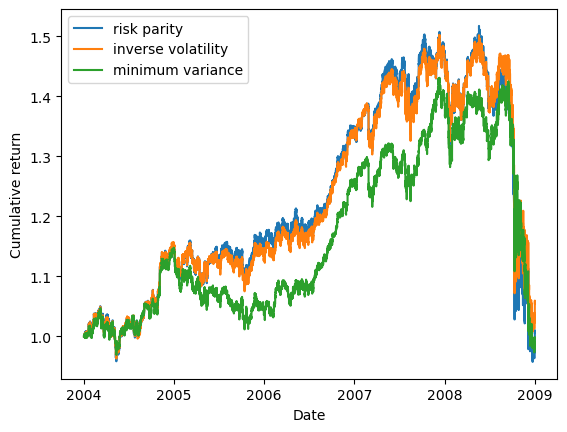

In [8]:
portfolio_cumprod = pd.read_parquet('data/clean/portfolio_cumprod_louvain_bahc.parquet')
plt.plot(portfolio_cumprod['rp_pf'], label = 'risk parity')
plt.plot(portfolio_cumprod['iv_pf'], label = 'inverse volatility')
plt.plot(portfolio_cumprod['mv_pf'], label = 'minimum variance')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.show()

## To visualize the performance together with S&P500 cumulative return

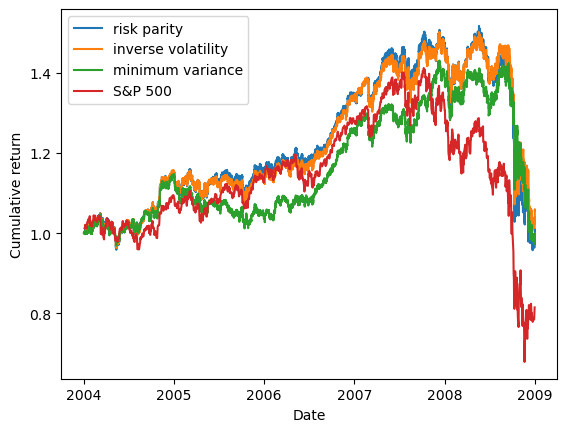

In [9]:
portfolio_cumprod = pd.read_parquet('data/clean/portfolio_cumprod_louvain_bahc.parquet')
path = "data/raw/sp100_2004-8/S&P 500 Historical Data.csv"
portfolio_cumprod_SP500 = SP500_returns(path)
plt.plot(portfolio_cumprod['rp_pf'], label = 'risk parity')
plt.plot(portfolio_cumprod['iv_pf'], label = 'inverse volatility')
plt.plot(portfolio_cumprod['mv_pf'], label = 'minimum variance')
plt.plot(portfolio_cumprod_SP500, label = 'S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.show()

# Marsili Giada clustering and clipped covariance matrix

In [ ]:
# run this cell only if you want to recreate the file already stored with the name "portfolio_cumprod_marsili_clipped.parquet"
returns = pd.read_parquet(f"data/clean/returns.parquet")
dates = returns.index.strftime("%Y-%m-%d").unique()
clusters_constituents, sub_portfolios, sub_portfolios_returns = clustering(returns, if_marsili_giada=True)
portfolio_cumprod, portfolio_return = portfolios_construction(clusters_constituents, returns, dates, sub_portfolios_returns, if_bahc=False)
portfolio_cumprod.to_parquet('data/clean/portfolio_cumprod_marsili_clipped.parquet')

## Strategies performance 

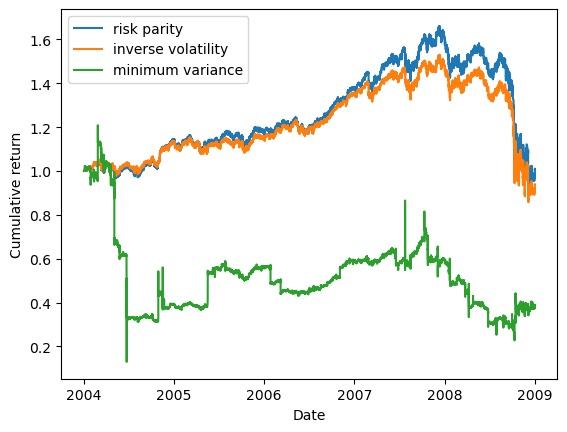

In [10]:
portfolio_cumprod = pd.read_parquet('data/clean/portfolio_cumprod_marsili_clipped.parquet')
plt.plot(portfolio_cumprod['rp_pf'], label = 'risk parity')
plt.plot(portfolio_cumprod['iv_pf'], label = 'inverse volatility')
plt.plot(portfolio_cumprod['mv_pf'], label = 'minimum variance')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.show()

## To visualize the performance together with S&P500 cumulative returns

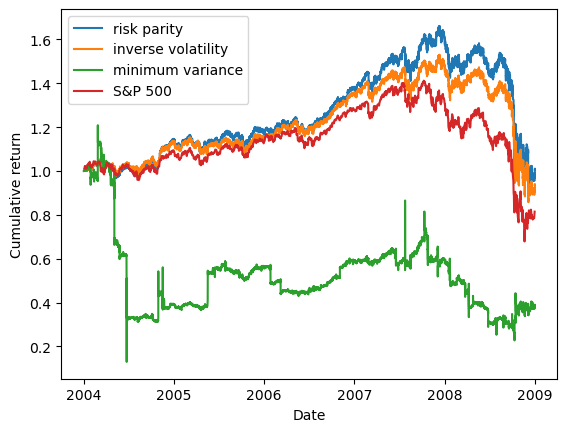

In [11]:
portfolio_cumprod = pd.read_parquet('data/clean/portfolio_cumprod_marsili_clipped.parquet')
path = "data/raw/sp100_2004-8/S&P 500 Historical Data.csv"
portfolio_cumprod_SP500 = SP500_returns(path)
plt.plot(portfolio_cumprod['rp_pf'], label = 'risk parity')
plt.plot(portfolio_cumprod['iv_pf'], label = 'inverse volatility')
plt.plot(portfolio_cumprod['mv_pf'], label = 'minimum variance')
plt.plot(portfolio_cumprod_SP500, label = 'S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.show()

# Louvain clustering and clipped covariance matrix

In [ ]:
# run this cell only if you want to recreate the file already stored with the name "portfolio_cumprod_louvain_clipped.parquet"
returns = pd.read_parquet(f"data/clean/returns.parquet")
dates = returns.index.strftime("%Y-%m-%d").unique()
clusters_constituents, sub_portfolios, sub_portfolios_returns = clustering(returns, if_marsili_giada=False)
portfolio_cumprod, portfolio_return = portfolios_construction(clusters_constituents, returns, dates, sub_portfolios_returns, if_bahc=False)
portfolio_cumprod.to_parquet('data/clean/portfolio_cumprod_louvain_clipped.parquet')

## Strategies performance

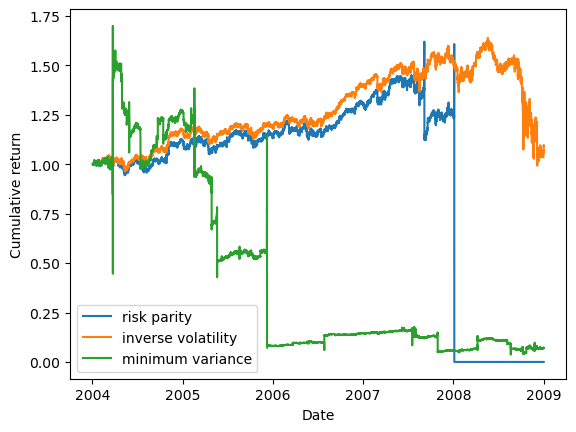

In [12]:
portfolio_cumprod = pd.read_parquet('data/clean/portfolio_cumprod_louvain_clipped.parquet')
plt.plot(portfolio_cumprod['rp_pf'], label = 'risk parity')
plt.plot(portfolio_cumprod['iv_pf'], label = 'inverse volatility')
plt.plot(portfolio_cumprod['mv_pf'], label = 'minimum variance')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.show()

## To visualize the performance together with S&P500 cumulative returns

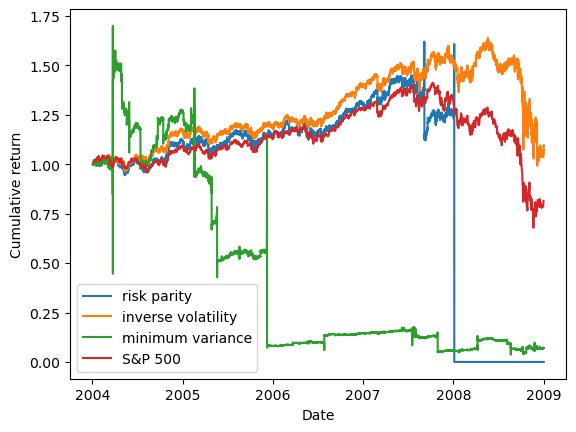

In [13]:
portfolio_cumprod = pd.read_parquet('data/clean/portfolio_cumprod_louvain_clipped.parquet')
path = "data/raw/sp100_2004-8/S&P 500 Historical Data.csv"
portfolio_cumprod_SP500 = SP500_returns(path)
plt.plot(portfolio_cumprod['rp_pf'], label = 'risk parity')
plt.plot(portfolio_cumprod['iv_pf'], label = 'inverse volatility')
plt.plot(portfolio_cumprod['mv_pf'], label = 'minimum variance')
plt.plot(portfolio_cumprod_SP500, label = 'S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.show()